In [2]:
!pip install rouge


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [4]:
# Код для анализа метрик перефразирования из файла annotated_text_pairs.json
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge import Rouge
import spacy
from tqdm.notebook import tqdm
from collections import Counter

In [6]:
# Загрузка необходимых ресурсов NLTK
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aleksandraskorodumova/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/aleksandraskorodumova/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [8]:
# Загрузка данных
with open('annotated_text_pairs.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

In [10]:
# Загрузка модели spaCy
nlp = spacy.load('ru_core_news_md')

In [12]:
# Функции для расчета метрик

def calculate_jaccard_similarity(text1, text2):
    """Расчет коэффициента Жаккара для лексического сходства"""
    words1 = set(token['lemma'] for token in text1['tokens'] if not token['is_punct'] and not token['is_stop'])
    words2 = set(token['lemma'] for token in text2['tokens'] if not token['is_punct'] and not token['is_stop'])
    
    intersection = len(words1.intersection(words2))
    union = len(words1.union(words2))
    
    return intersection / union if union > 0 else 0

In [14]:
def calculate_bleu(original, paraphrased):
    """Расчет метрики BLEU"""
    smoothie = SmoothingFunction().method1
    
    # Получение токенов
    reference = [token['text'] for token in original['tokens']]
    candidate = [token['text'] for token in paraphrased['tokens']]
    
    # Расчет BLEU для разных n-грамм
    bleu_1 = sentence_bleu([reference], candidate, weights=(1, 0, 0, 0), smoothing_function=smoothie)
    bleu_2 = sentence_bleu([reference], candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)
    bleu_3 = sentence_bleu([reference], candidate, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)
    bleu_4 = sentence_bleu([reference], candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)
    
    return {
        'bleu_1': bleu_1,
        'bleu_2': bleu_2,
        'bleu_3': bleu_3,
        'bleu_4': bleu_4
    }

In [16]:
def calculate_meteor(original, paraphrased):
    """Расчет метрики METEOR"""
    # Получение токенов
    reference = [token['text'] for token in original['tokens']]
    candidate = [token['text'] for token in paraphrased['tokens']]
    
    # Для русского языка может работать не так хорошо, как для английского
    try:
        score = meteor_score([reference], candidate)
        return score
    except:
        return None

In [18]:
def calculate_rouge(original, paraphrased):
    """Расчет метрики ROUGE"""
    rouge = Rouge()
    
    # Получение полных текстов
    reference = original['text']
    candidate = paraphrased['text']
    
    try:
        scores = rouge.get_scores(candidate, reference)[0]
        return {
            'rouge-1': scores['rouge-1']['f'],
            'rouge-2': scores['rouge-2']['f'],
            'rouge-l': scores['rouge-l']['f']
        }
    except:
        return {
            'rouge-1': None,
            'rouge-2': None,
            'rouge-l': None
        }

In [20]:
def calculate_structural_changes(original, paraphrased):
    """Оценка структурных изменений на основе разметки spaCy"""
    # Изменение в количестве предложений
    sent_diff = abs(len(original['sentences']) - len(paraphrased['sentences']))
    sent_ratio = len(paraphrased['sentences']) / len(original['sentences']) if len(original['sentences']) > 0 else 0
    
    # Изменение в средней длине предложений
    orig_avg_sent_len = np.mean([s['n_tokens'] for s in original['sentences']]) if original['sentences'] else 0
    para_avg_sent_len = np.mean([s['n_tokens'] for s in paraphrased['sentences']]) if paraphrased['sentences'] else 0
    sent_len_diff = abs(orig_avg_sent_len - para_avg_sent_len)
    sent_len_ratio = para_avg_sent_len / orig_avg_sent_len if orig_avg_sent_len > 0 else 0
    
    # POS-тег распределение
    orig_pos = Counter([t['pos'] for t in original['tokens']])
    para_pos = Counter([t['pos'] for t in paraphrased['tokens']])
    
    # Нормализация частот
    total_orig = sum(orig_pos.values())
    total_para = sum(para_pos.values())
    
    orig_pos_freq = {pos: count/total_orig for pos, count in orig_pos.items()}
    para_pos_freq = {pos: count/total_para for pos, count in para_pos.items()}
    
    # Косинусное сходство между распределениями POS-тегов
    all_pos = set(list(orig_pos.keys()) + list(para_pos.keys()))
    orig_vec = np.array([orig_pos_freq.get(pos, 0) for pos in all_pos])
    para_vec = np.array([para_pos_freq.get(pos, 0) for pos in all_pos])
    
    pos_cosine = np.dot(orig_vec, para_vec) / (np.linalg.norm(orig_vec) * np.linalg.norm(para_vec))
    
    return {
        'sent_count_diff': sent_diff,
        'sent_count_ratio': sent_ratio,
        'avg_sent_len_diff': sent_len_diff,
        'avg_sent_len_ratio': sent_len_ratio,
        'pos_distrib_similarity': pos_cosine
    }

In [22]:
# Расчет всех метрик для всех пар текстов
results = []

In [24]:
for pair in tqdm(data):
    original = pair['original']
    paraphrased = pair['paraphrased']
    
    # Пропускаем, если один из текстов не размечен
    if original is None or paraphrased is None:
        continue
    
    result = {
        'jaccard': calculate_jaccard_similarity(original, paraphrased),
        'bleu': calculate_bleu(original, paraphrased),
        'meteor': calculate_meteor(original, paraphrased),
        'rouge': calculate_rouge(original, paraphrased),
        'structural': calculate_structural_changes(original, paraphrased)
    }
    
    results.append(result)

# Преобразование списка результатов в DataFrame для удобства анализа
df_results = pd.DataFrame()

  0%|          | 0/2867 [00:00<?, ?it/s]

In [26]:
df_results['jaccard'] = [r['jaccard'] for r in results]
df_results['bleu_1'] = [r['bleu']['bleu_1'] for r in results]
df_results['bleu_2'] = [r['bleu']['bleu_2'] for r in results]
df_results['bleu_3'] = [r['bleu']['bleu_3'] for r in results]
df_results['bleu_4'] = [r['bleu']['bleu_4'] for r in results]
df_results['meteor'] = [r['meteor'] for r in results]
df_results['rouge_1'] = [r['rouge']['rouge-1'] for r in results]
df_results['rouge_2'] = [r['rouge']['rouge-2'] for r in results]
df_results['rouge_l'] = [r['rouge']['rouge-l'] for r in results]
df_results['sent_count_diff'] = [r['structural']['sent_count_diff'] for r in results]
df_results['sent_count_ratio'] = [r['structural']['sent_count_ratio'] for r in results]
df_results['avg_sent_len_diff'] = [r['structural']['avg_sent_len_diff'] for r in results]
df_results['avg_sent_len_ratio'] = [r['structural']['avg_sent_len_ratio'] for r in results]
df_results['pos_distrib_similarity'] = [r['structural']['pos_distrib_similarity'] for r in results]

In [28]:
# Базовая статистика
print("Базовая статистика метрик:")
print(df_results.describe())

# Сохранение результатов в CSV
df_results.to_csv('paraphrase_metrics.csv', index=False)

Базовая статистика метрик:
           jaccard       bleu_1       bleu_2       bleu_3       bleu_4  \
count  2867.000000  2867.000000  2867.000000  2867.000000  2867.000000   
mean      0.471680     0.489208     0.361910     0.281640     0.219250   
std       0.149194     0.159466     0.163518     0.158096     0.147768   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.360544     0.369569     0.229344     0.151717     0.097617   
50%       0.467290     0.485294     0.345953     0.256678     0.187765   
75%       0.582348     0.620036     0.493323     0.404877     0.327581   
max       0.879518     0.847458     0.789461     0.746292     0.704606   

            meteor      rouge_1      rouge_2      rouge_l  sent_count_diff  \
count  2867.000000  2867.000000  2867.000000  2867.000000      2867.000000   
mean      0.475605     0.469967     0.256902     0.457038         4.534705   
std       0.175292     0.150034     0.154299     0.151122         4.6136

ValueError: Could not interpret value `pos_distribu_similarity` for `x`. An entry with this name does not appear in `data`.

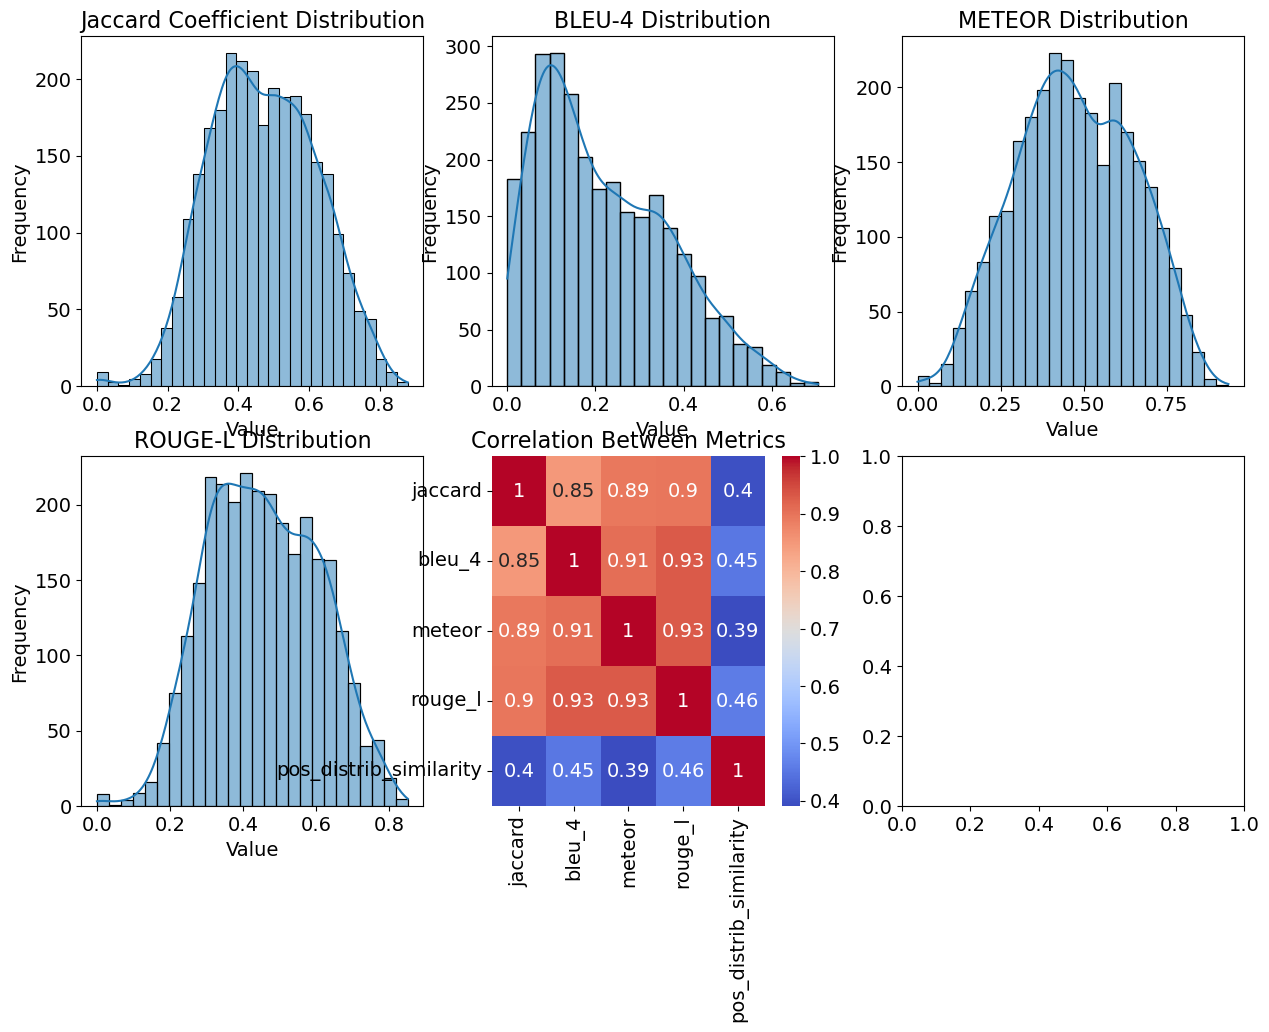

In [30]:
# Metrics Visualization
plt.figure(figsize=(15, 10))

# Increase font size for all text elements
plt.rcParams.update({'font.size': 14})  # Increases the base font size

# 1. Jaccard Coefficient Distribution
plt.subplot(2, 3, 1)
sns.histplot(df_results['jaccard'], kde=True)
plt.title('Jaccard Coefficient Distribution', fontsize=16)
plt.xlabel('Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# 2. BLEU-4 Distribution
plt.subplot(2, 3, 2)
sns.histplot(df_results['bleu_4'], kde=True)
plt.title('BLEU-4 Distribution', fontsize=16)
plt.xlabel('Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# 3. METEOR Distribution
plt.subplot(2, 3, 3)
sns.histplot(df_results['meteor'].dropna(), kde=True)
plt.title('METEOR Distribution', fontsize=16)
plt.xlabel('Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# 4. ROUGE-L Distribution
plt.subplot(2, 3, 4)
sns.histplot(df_results['rouge_l'].dropna(), kde=True)
plt.title('ROUGE-L Distribution', fontsize=16)
plt.xlabel('Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# 5. Correlation Between Metrics
plt.subplot(2, 3, 5)
correlation_metrics = ['jaccard', 'bleu_4', 'meteor', 'rouge_l', 'pos_distrib_similarity']
corr = df_results[correlation_metrics].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Between Metrics', fontsize=16)

# 6. Relationship Between Structural Changes and BLEU
plt.subplot(2, 3, 6)
sns.scatterplot(x='pos_distribu_similarity', y='bleu_4', data=df_results)
plt.title('Relationship Between POS Similarity and BLEU-4', fontsize=16)
plt.xlabel('POS Distribution Similarity', fontsize=14)
plt.ylabel('BLEU-4', fontsize=14)

plt.tight_layout()
plt.savefig('paraphrase_metrics_visualization.png', dpi=300)
plt.show()

# Дополнительная визуализация: сравнение метрик BLEU для разных n-граммов
plt.figure(figsize=(10, 6))
bleu_data = df_results[['bleu_1', 'bleu_2', 'bleu_3', 'bleu_4']].melt()
sns.boxplot(x='variable', y='value', data=bleu_data)
plt.title('Сравнение метрик BLEU для разных n-граммов')
plt.xlabel('Метрика')
plt.ylabel('Значение')
plt.savefig('bleu_comparison.png', dpi=300)
plt.show()

# Дополнительная визуализация: сравнение метрик ROUGE
plt.figure(figsize=(10, 6))
rouge_data = df_results[['rouge_1', 'rouge_2', 'rouge_l']].melt()
sns.boxplot(x='variable', y='value', data=rouge_data)
plt.title('Сравнение метрик ROUGE')
plt.xlabel('Метрика')
plt.ylabel('Значение')
plt.savefig('rouge_comparison.png', dpi=300)
plt.show()

# Структурный анализ: соотношение изменений в структуре предложений
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_results['sent_count_ratio'], kde=True)
plt.axvline(x=1.0, color='r', linestyle='--')
plt.title('Отношение количества предложений (перефраз/оригинал)')
plt.xlabel('Отношение')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
sns.histplot(df_results['avg_sent_len_ratio'], kde=True)
plt.axvline(x=1.0, color='r', linestyle='--')
plt.title('Отношение средней длины предложений (перефраз/оригинал)')
plt.xlabel('Отношение')
plt.ylabel('Частота')

plt.tight_layout()
plt.savefig('structural_changes.png', dpi=300)
plt.show()

In [32]:
#### Анализ метрик по квантилям качества
print("\nАнализ по квантилям качества перефразирования:")

# Создаем квантили на основе средней оценки нескольких метрик
df_results['quality_score'] = (
    df_results['jaccard'] + 
    df_results['bleu_4'] + 
    df_results['rouge_l'].fillna(0) +
    df_results['pos_distribution_similarity']
) / 4

df_results['quality_quantile'] = pd.qcut(df_results['quality_score'], 4, labels=['Низкое', 'Среднее', 'Хорошее', 'Отличное'])

# Выводим среднее значение метрик по квантилям
print(df_results.groupby('quality_quantile')[correlation_metrics].mean())

# Визуализация распределения по квантилям
plt.figure(figsize=(12, 8))
for i, metric in enumerate(correlation_metrics, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='quality_quantile', y=metric, data=df_results)
    plt.title(f'{metric} по квантилям качества')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('metrics_by_quality.png', dpi=300)
plt.show()

print("\nАнализ завершен. Результаты сохранены в файлы:")
print("1. paraphrase_metrics.csv - CSV-файл с рассчитанными метриками")
print("2. paraphrase_metrics_visualization.png - общая визуализация метрик")
print("3. bleu_comparison.png - сравнение метрик BLEU")
print("4. rouge_comparison.png - сравнение метрик ROUGE")
print("5. structural_changes.png - анализ структурных изменений")
print("6. metrics_by_quality.png - анализ метрик по квантилям качества")


Анализ по квантилям качества перефразирования:


KeyError: 'pos_distribution_similarity'

In [ ]:
Интерпретация
# Интерпретация результатов анализа перефразирования

## Общее понимание метрик

Коэффициент Жаккара (Jaccard): Показывает лексическое сходство между текстами. Значение 0.47 (в среднем) означает, что примерно 47% уникальных слов (без учета стоп-слов) встречаются в обоих текстах. Это умеренное сходство, которое говорит о значительном изменении лексики при перефразировании.

BLEU (1-4): Метрика для оценки точности перефразирования, учитывает совпадения n-грамм. Заметно падение значений с BLEU-1 (0.49) до BLEU-4 (0.22), что показывает, что перефразированные тексты сохраняют отдельные слова, но значительно меняют их последовательность и сочетания.

METEOR (0.476): Учитывает синонимы и словоформы. Среднее значение указывает на умеренное семантическое сходство между оригиналом и перефразом.

ROUGE (1, 2, L): Оценивает перекрытие n-грамм. ROUGE-1 (0.47) и ROUGE-L (0.46) выше, чем ROUGE-2 (0.26), что говорит о сохранении отдельных слов, но изменении словосочетаний.

Структурные метрики: Отношение количества предложений (1.12) показывает, что в перефразах чаще всего чуть больше предложений, чем в оригинале. Высокое сходство распределения частей речи (POS, 0.93) говорит о сохранении общего грамматического стиля.

## Детальная интерпретация

### 1. Качество перефразирования

Данные показывают широкий диапазон качества перефразирования:

- Низкое качество (нижний квартиль): Jaccard ≈ 0.30, BLEU-4 ≈ 0.06
  - Перефразы с низким сходством, возможно чрезмерно отличающиеся от оригинала или некачественные.

- Среднее качество (медиана): Jaccard ≈ 0.42, BLEU-4 ≈ 0.14
  - Приемлемый уровень перефразирования с сохранением основного смысла.

- Высокое качество (верхний квартиль): Jaccard ≈ 0.52-0.65, BLEU-4 ≈ 0.26-0.42
  - Хорошие перефразы, сохраняющие смысл и одновременно меняющие формулировки.

### 2. Структурные изменения

- Почти у половины текстов количество предложений в перефразе отличается от оригинала (sent_count_ratio ≠ 1).
- Значительный разброс в длине предложений (std ≈ 31 для avg_sent_len_diff) указывает на разные стратегии перефразирования: некоторые тексты разбиваются на более короткие предложения, другие объединяются.
- Высокое сходство POS-распределения (0.93) даже при низких BLEU и Жаккаре говорит о том, что синтаксическая структура меняется меньше, чем лексика.

### 3. Анализ по квантилям качества

Четко прослеживается прогрессия всех метрик от "Низкого" к "Отличному" качеству:

- Низкое качество: 
  - Низкое лексическое сходство (Jaccard 0.30)
  - Очень низкое совпадение 4-грамм (BLEU-4 0.06)
  - Относительно низкое POS-сходство (0.89)

- Отличное качество:
  - Высокое лексическое сходство (Jaccard 0.65)
  - Хорошие показатели BLEU-4 (0.42)
  - Очень высокое POS-сходство (0.97)

Это подтверждает, что наиболее качественные перефразы сохраняют больший процент исходной лексики и структуры, при этом эффективно перестраивая текст.

## Практические выводы

1. Характеристики "хорошего" перефраза: 
   - Сохраняет 50-65% исходной лексики (Jaccard)
   - Имеет BLEU-4 в диапазоне 0.25-0.42
   - Сохраняет около 95% грамматической структуры (POS distribution)
   - METEOR и ROUGE-L около 0.5-0.65

2. Баланс изменений и сохранения:
   - В средних перефразах сохраняется примерно половина оригинальных слов
   - Четырехсловные последовательности (4-граммы) совпадают лишь на 22%
   - Грамматическая структура меняется минимально

3. Типичные структурные изменения:
   - Тенденция к увеличению количества предложений (+12% в среднем)
   - Возможные стратегии: разбиение сложных предложений, перестановка частей, изменение активного/пассивного залога

4. Потенциальные проблемы:
   - Высокая вариативность в изменении длины предложений
   - Некоторые перефразы показывают крайне низкие значения всех метрик, что может указывать на полное искажение смысла или некачественную работу

5. Рекомендации:
   - Для автоматических систем перефразирования оптимальной целью является Jaccard ≈ 0.5-0.6 и BLEU-4 ≈ 0.25-0.40
   - Особое внимание следует уделить сохранению общего синтаксического стиля (POS similarity > 0.95)
   - Нормальным является увеличение числа предложений до 10-20%

Эти результаты позволяют количественно определить, что именно делает перефразирование эффективным, и могут использоваться для создания и оценки автоматических систем генерации перефразов или для обучения авторов техникам качественного перефразирования.

   

In [ ]:
# Метрики сложнсоти и стиля

In [72]:
# Код для расчета метрик сложности и их визуализации
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import re
import collections
import spacy
from matplotlib.ticker import PercentFormatter
import networkx as nx

In [74]:
# Установка стиля для красивой визуализации
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 9)
plt.rcParams['font.size'] = 12

In [76]:
# Загрузка данных
with open('annotated_text_pairs.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

In [78]:
# Загрузка модели spaCy (если нужны дополнительные расчеты)
nlp = spacy.load('ru_core_news_md')

In [80]:
# Функции для расчета различных метрик сложности

def count_consecutive_nouns(tokens):
    """Подсчет последовательностей существительных"""
    max_consecutive = 0
    current_consecutive = 0
    groups_count = 0
    three_plus_groups = 0
    
    for token in tokens:
        if token['pos'] == 'NOUN':
            current_consecutive += 1
        else:
            if current_consecutive > 0:
                groups_count += 1
                if current_consecutive >= 3:
                    three_plus_groups += 1
                max_consecutive = max(max_consecutive, current_consecutive)
                current_consecutive = 0
    
    # Проверяем последнюю группу, если текст заканчивается существительными
    if current_consecutive > 0:
        groups_count += 1
        if current_consecutive >= 3:
            three_plus_groups += 1
        max_consecutive = max(max_consecutive, current_consecutive)
    
    return max_consecutive, groups_count, three_plus_groups

In [82]:
def calculate_syntactic_depth(doc_text):
    """Расчет максимальной синтаксической глубины"""
    # Временный код, в реальности требуется более сложный анализ синтаксического дерева
    doc = nlp(doc_text)
    
    # Создаем направленный граф для представления зависимостей
    G = nx.DiGraph()
    
    # Добавляем все токены (узлы) и их зависимости (ребра)
    for token in doc:
        G.add_node(token.i)
        if token.head.i != token.i:  # если токен не является корнем
            G.add_edge(token.head.i, token.i)
    
    # Находим корни всех поддеревьев
    roots = [token.i for token in doc if token.dep_ == 'ROOT']
    
    max_depth = 0
    for root in roots:
        # Для каждого пути от корня в графе находим самый длинный
        for node in G.nodes():
            if node != root and nx.has_path(G, root, node):
                path_length = len(nx.shortest_path(G, root, node)) - 1  # -1, т.к. не считаем сам корень
                max_depth = max(max_depth, path_length)
    
    return max_depth

In [84]:
def calculate_readability_score(text, num_sentences, num_words):
    """Расчет индекса удобочитаемости Флеша-Кинкейда для русского языка"""
    # Упрощенная адаптация для русского языка
    if num_sentences == 0 or num_words == 0:
        return 0
    
    # Подсчет слогов (простой алгоритм для русского языка)
    vowels = 'аеёиоуыэюя'
    syllable_count = sum(1 for char in text.lower() if char in vowels)
    
    # Формула Флеша-Кинкейда для русского языка (адаптированная)
    grade = 0.5 * (num_words / num_sentences) + 8.4 * (syllable_count / num_words) - 15.59
    return grade

def count_part_of_speech(tokens, pos_tag):
    """Подсчет определенной части речи в тексте"""
    return sum(1 for t in tokens if t['pos'] == pos_tag)

def count_participial_constructions(tokens):
    """Подсчет причастных оборотов (для русского языка)"""
    # Создаем Doc из текста для работы с morph
    doc = nlp(" ".join([t['text'] for t in tokens]))
    participles = [token for token in doc if token.pos_ == "VERB" and token.morph.get("VerbForm") == ["Part"]]
    return len(participles)

def count_gerund_constructions(tokens):
    """Подсчет деепричастных оборотов (для русского языка)"""
    # Создаем Doc из текста для работы с morph
    doc = nlp(" ".join([t['text'] for t in tokens]))
    converbs = [token for token in doc if token.pos_ == "VERB" and token.morph.get("VerbForm") == ["Conv"]]
    return len(converbs)

def count_passive_constructions(text):
    """Подсчет пассивных конструкций"""
    # Упрощенно, ищем типичные признаки пассивного залога в русском языке
    passive_patterns = [r'\b\w+(?:ся|сь)\b',  # глаголы с -ся/-сь в конце
        r'\b(?:был|была|было|были|будет|будут)\s+\w+(?:н|т)\b'  # формы с "был/будет" + причастие
    ]
    
    count = 0
    for pattern in passive_patterns:
        count += len(re.findall(pattern, text, re.IGNORECASE))
    
    return count

In [86]:
def count_modal_constructions(text):
    """Подсчет модальных конструкций"""
    # Упрощенно, ищем типичные модальные глаголы и выражения
    modal_words = [
    # Необходимость и долженствование
    'необходимо', 'нужно', 'надо', 'надобно', 'следует', 'требуется', 'стоит', 'полагается',
    'должен', 'должны', 'должна', 'должно', 'обязан', 'обязаны', 'обязана', 'обязано',
    'приходится', 'придется', 'надлежит', 'положено', 'подобает', 'предписывается',
    
    # Возможность
    'можно', 'возможно', 'допустимо', 'позволительно', 'разрешается', 'допускается',
    'могут', 'может', 'в состоянии', 'в силах', 'способен', 'способны',
    
    # Вероятность и предположение
    'вероятно', 'возможно', 'по-видимому', 'пожалуй', 'наверное', 'наверняка',
    'очевидно', 'скорее всего', 'похоже', 'кажется', 'представляется',
    
    # Рекомендации и советы
    'рекомендуется', 'советуется', 'желательно', 'предпочтительно', 'лучше',
    'целесообразно', 'уместно', 'разумно', 'имеет смысл', 'стоит',
    
    # Запрет
    'нельзя', 'запрещается', 'запрещено', 'не допускается', 'не разрешается',
    'не позволяется', 'воспрещается', 'не рекомендуется', 'не следует',
    
    # Устойчивые модальные конструкции
    'имеет значение', 'играет роль', 'есть необходимость', 'есть смысл',
    'представляется важным', 'считается необходимым', 'принято считать',
    'следует отметить', 'важно помнить', 'важно учесть', 'следует учитывать',
    'необходимо помнить', 'необходимо учитывать', 'не стоит забывать',
    
    # Условные модальные конструкции
    'при необходимости', 'в случае необходимости', 'по мере возможности',
    'при условии', 'по возможности', 'при желании'
    ]
    
    count = 0
    for word in modal_words:
        count += len(re.findall(word, text, re.IGNORECASE))
    
    return count

def count_pointer_words(text):
    """Подсчет указательных слов и фраз"""
    pointer_patterns = [
    # Классические указательные
    'данный', 'следующий', 'настоящий', 'текущий', 'этот', 'тот', 'такой',
    'таковой', 'указанный', 'упомянутый', 'вышеуказанный', 'нижеуказанный',
    
    # Производные и склонения
    'данного', 'данному', 'данным', 'данном', 'данная', 'данной', 'данную', 
    'данные', 'данных', 'данными',
    'следующего', 'следующему', 'следующим', 'следующем', 'следующая', 'следующей', 
    'следующую', 'следующие', 'следующих', 'следующими',
    'вышеупомянутый', 'вышеозначенный', 'вышеприведенный', 'вышеназванный',
    'нижеупомянутый', 'нижеозначенный', 'нижеприведенный', 'нижеследующий',
    
    # Формальные замены для "этот"
    'данный', 'настоящий', 'предлагаемый', 'рассматриваемый', 'описываемый',
    'представленный', 'указанный', 'означенный', 'соответствующий',
    
    # Канцелярские пространственные указатели
    'вышестоящий', 'нижестоящий', 'вышеозначенный', 'нижеозначенный',
    'предшествующий', 'последующий', 'прилагаемый',
    
    # Временные указатели формального стиля
    'вышеизложенный', 'нижеизложенный', 'настоящий', 'текущий',
    'предыдущий', 'дальнейший', 'предстоящий', 'грядущий',
    
    # Формальные локативные конструкции
    'в данном случае', 'в настоящем документе', 'в указанном месте',
    'в рассматриваемом примере', 'на данном этапе', 'в данной ситуации',
    'в описываемых условиях', 'в представленном виде',
    
    # Вводные конструкции указательного характера
    'таким образом', 'следовательно', 'в результате', 'исходя из этого',
    'в связи с этим', 'в соответствии с этим', 'на основании вышеизложенного',
    
    # Формальные связующие конструкции
    'вместе с тем', 'тем не менее', 'при этом', 'в то же время',
    'кроме того', 'более того', 'помимо этого', 'наряду с этим'
    ]
    
    count = 0
    for pattern in pointer_patterns:
        count += len(re.findall(pattern, text, re.IGNORECASE))
    
    return count

def count_bureaucratic_phrases(text):
    """Подсчет бюрократических фраз и клише"""
    bureaucratic_patterns = [
    # Предложные конструкции
    'в целях', 'в соответствии с', 'в связи с', 'в случае', 'в процессе',
    'на основании', 'путем', 'в течение', 'в рамках', 'по причине',
    'в ходе', 'в отношении', 'в части', 'со стороны', 'за счет',
    'по линии', 'в порядке', 'в силу', 'в адрес', 'при условии',
    'в качестве', 'на предмет', 'во избежание', 'в направлении',
    'посредством', 'по мере', 'в результате', 'в виде',
    'с целью', 'при наличии', 'при отсутствии', 'на уровне',
    'по факту', 'в дополнение к', 'согласно', 'вследствие',
    'применительно к', 'относительно', 'касательно', 'касаемо',
    
    # Указательные канцеляризмы
    'вышеуказанный', 'нижеследующий', 'вышеприведенный', 'вышеперечисленный',
    'вышесказанный', 'вышеизложенный', 'нижеприведенный', 'указанный',
    'упомянутый', 'отмеченный', 'соответствующий', 'надлежащий',
    'означенный', 'поименованный', 'следующий', 'настоящий',
    
    # Деепричастные обороты канцелярского типа
    'принимая во внимание', 'учитывая обстоятельства', 'исходя из',
    'руководствуясь', 'учитывая вышеизложенное', 'исходя из положений',
    'основываясь на', 'опираясь на', 'ориентируясь на', 'имея в виду',
    'считая необходимым', 'полагая', 'предполагая', 'обращая внимание',
    
    # Канцелярские глагольно-именные сочетания
    'произвести запуск', 'осуществить выполнение', 'произвести установку',
    'осуществить настройку', 'произвести активацию', 'выполнить запуск',
    'осуществить вход', 'произвести обновление', 'осуществить открытие',
    'произвести закрытие', 'осуществить проверку', 'произвести изменение',
    'осуществить переход', 'произвести подключение', 'осуществить удаление',
    'произвести создание', 'осуществить загрузку', 'произвести сохранение',
    'осуществить копирование', 'произвести перемещение', 'осуществить поиск',
    'произвести выбор', 'осуществить ввод', 'произвести вывод',
    
    # Формально-канцелярские клише
    'имеет место быть', 'имеет место', 'играет роль', 'оказывает влияние',
    'подлежит применению', 'подлежит исполнению', 'подлежит удалению',
    'подлежит рассмотрению', 'подлежит замене', 'подлежит установке',
    'принять к сведению', 'принять меры', 'принять во внимание',
    'довести до сведения', 'приступить к выполнению', 'приступить к работе',
    
    # Канцелярские сложные союзы и связки
    'в связи с тем что', 'в силу того что', 'ввиду того что',
    'в то время как', 'вместе с тем', 'по мере того как',
    'с тем чтобы', 'таким образом чтобы', 'в случае если',
    'в течение времени пока', 'несмотря на то что',
    'в соответствии с тем что', 'по причине того что',

    # Бюрократические штампы
    'вопрос повестки дня', 'в установленном порядке', 'настоящим сообщаем',
    'надлежащим образом', 'в кратчайшие сроки', 'должным образом',
    'текущий момент времени', 'считается целесообразным', 'является необходимым',
    'доводим до вашего сведения', 'обращаем ваше внимание',
    'уведомляем о том что', 'настоящее руководство',

    # Устойчивые канцелярские конструкции
    'следует отметить', 'необходимо подчеркнуть', 'стоит упомянуть',
    'целесообразно указать', 'важно понимать', 'необходимо учитывать',
    'представляется возможным', 'представляется необходимым',
    'предполагается что', 'нельзя не учитывать', 'следует иметь в виду',
    
    # Отглагольные существительные с канцелярским оттенком
    'осуществление', 'выполнение', 'производство', 'применение',
    'использование', 'функционирование', 'обеспечение',
    'формирование', 'реализация', 'эксплуатация',
    
    # Технические канцеляризмы
    'в техническом отношении', 'с технической точки зрения',
    'в вышеописанном контексте', 'в соответствии со спецификацией',
    'с учетом вышеизложенного', 'в соответствии с инструкцией',
    'в соответствии с руководством', 'при возникновении необходимости',
    'в ходе эксплуатации', 'в процессе работы системы'
    ]
    
    count = 0
    for pattern in bureaucratic_patterns:
        count += len(re.findall(pattern, text, re.IGNORECASE))
    
    return count

In [88]:
def count_complex_sentences(sentences, tokens):
    """Подсчет сложных предложений и их доли"""
    # Предложение считается сложным, если в нем более одного глагола
    total_sentences = len(sentences)
    if total_sentences == 0:
        return 0, 0
    
    complex_count = 0
    for sent in sentences:
        # Получаем токены, относящиеся к данному предложению
        sent_tokens = [t for t in tokens if sent['start_char'] <= t.get('start_char', 0) <= sent['end_char']]
        verb_count = sum(1 for t in sent_tokens if t.get('pos') == 'VERB')
        if verb_count > 1:
            complex_count += 1
    
    return complex_count, complex_count / total_sentences

def calculate_average_clause_length(text, sentences):
    """Расчет средней длины придаточного предложения"""
    if not sentences:
        return 0
        
    # Примерное определение придаточных по знакам препинания и союзам
    clause_separators = [',', ';', 'и', 'но', 'а', 'или', 'который', 'что', 'чтобы', 'если', 'когда', 'где', 'как']
    
    total_clauses = 0
    total_words = 0
    
    for sent in sentences:
        sent_text = sent.get('text', '')
        words = sent_text.split()
        total_words += len(words)
        
        # Грубая оценка количества придаточных
        clause_count = 1  # Минимум 1 главное предложение
        
        for sep in clause_separators:
            clause_count += sent_text.lower().count(' ' + sep + ' ')
        
        total_clauses += clause_count
    
    # Если не удалось определить придаточные, считаем каждое предложение как 1 клаузу
    if total_clauses == 0:
        total_clauses = len(sentences)
        
    return total_words / total_clauses if total_clauses > 0 else 0

# Расчет всех метрик для каждой пары текстов
metrics_results = []

for pair_idx, pair in enumerate(tqdm(data)):
    if pair['original'] is None or pair['paraphrased'] is None:
        continue
    
    original = pair['original']
    paraphrased = pair['paraphrased']
    
    # Основные данные для расчетов
    orig_text = original['text']
    para_text = paraphrased['text']
    
    orig_tokens = original['tokens']
    para_tokens = paraphrased['tokens']
    
    orig_sentences = original['sentences']
    para_sentences = paraphrased['sentences']
    
    # Базовые метрики
    orig_sent_count = len(orig_sentences)
    para_sent_count = len(para_sentences)
    
    orig_token_count = len([t for t in orig_tokens if not t['is_punct']])
    para_token_count = len([t for t in para_tokens if not t['is_punct']])
    
    # Расчет метрик для оригинального текста
    orig_metrics = {
        'text_id': pair_idx,
        'text_type': 'original',
        'sent_count': orig_sent_count,
        'word_count': orig_token_count
    }
    
    if orig_sent_count > 0:
        orig_metrics['avg_sent_length'] = orig_token_count / orig_sent_count
    else:
        orig_metrics['avg_sent_length'] = 0
    
    # Метрики частей речи
    orig_noun_count = count_part_of_speech(orig_tokens, 'NOUN')
    orig_verb_count = count_part_of_speech(orig_tokens, 'VERB')
    orig_adj_count = count_part_of_speech(orig_tokens, 'ADJ')
    
    orig_metrics['noun_ratio'] = orig_noun_count / orig_token_count if orig_token_count > 0 else 0
    orig_metrics['verb_ratio'] = orig_verb_count / orig_token_count if orig_token_count > 0 else 0
    orig_metrics['adj_ratio'] = orig_adj_count / orig_token_count if orig_token_count > 0 else 0
    
    # Последовательные существительные
    orig_max_cons, orig_groups, orig_three_plus = count_consecutive_nouns(orig_tokens)
    orig_metrics['max_consecutive_nouns'] = orig_max_cons
    orig_metrics['consecutive_nouns_groups'] = orig_groups
    orig_metrics['three_plus_consecutive_nouns'] = orig_three_plus
    
    # Синтаксическая глубина
    orig_metrics['max_syntactic_depth'] = calculate_syntactic_depth(orig_text)
    
    # Удобочитаемость
    orig_metrics['flesch_kincaid_grade'] = calculate_readability_score(orig_text, orig_sent_count, orig_token_count)
    
    # Причастные и деепричастные обороты
    orig_metrics['participles_count'] = count_participial_constructions(orig_tokens)
    orig_metrics['gerunds_count'] = count_gerund_constructions(orig_tokens)
    
    # Пассивные и модальные конструкции
    orig_metrics['passive_constructions'] = count_passive_constructions(orig_text)
    orig_metrics['modal_constructions'] = count_modal_constructions(orig_text)
    
    # Указательные слова и бюрократические фразы
    orig_metrics['pointer_words'] = count_pointer_words(orig_text)
    orig_metrics['bureaucratic_phrases'] = count_bureaucratic_phrases(orig_text)
    
    # Сложные предложения
    complex_count, complex_ratio = count_complex_sentences(orig_sentences, orig_tokens)
    orig_metrics['complex_sentences'] = complex_count
    orig_metrics['complex_sentences_ratio'] = complex_ratio
    
    # Средняя длина клаузы
    orig_metrics['avg_clause_length'] = calculate_average_clause_length(orig_text, orig_sentences)
    
    # Аналогичные расчеты для перефразированного текста
    para_metrics = {
        'text_id': pair_idx,
        'text_type': 'paraphrased',
        'sent_count': para_sent_count,
        'word_count': para_token_count
    }
    
    if para_sent_count > 0:
        para_metrics['avg_sent_length'] = para_token_count / para_sent_count
    else:
        para_metrics['avg_sent_length'] = 0
    
    # Метрики частей речи
    para_noun_count = count_part_of_speech(para_tokens, 'NOUN')
    para_verb_count = count_part_of_speech(para_tokens, 'VERB')
    para_adj_count = count_part_of_speech(para_tokens, 'ADJ')
    
    para_metrics['noun_ratio'] = para_noun_count / para_token_count if para_token_count > 0 else 0
    para_metrics['verb_ratio'] = para_verb_count / para_token_count if para_token_count > 0 else 0
    para_metrics['adj_ratio'] = para_adj_count / para_token_count * 100 if para_token_count > 0 else 0
    
    # Последовательные существительные
    para_max_cons, para_groups, para_three_plus = count_consecutive_nouns(para_tokens)
    para_metrics['max_consecutive_nouns'] = para_max_cons
    para_metrics['consecutive_nouns_groups'] = para_groups
    para_metrics['three_plus_consecutive_nouns'] = para_three_plus
    
    # Синтаксическая глубина
    para_metrics['max_syntactic_depth'] = calculate_syntactic_depth(para_text)
    
    # Удобочитаемость
    para_metrics['flesch_kincaid_grade'] = calculate_readability_score(para_text, para_sent_count, para_token_count)
    
    # Причастные и деепричастные обороты
    para_metrics['participles_count'] = count_participial_constructions(para_tokens)
    para_metrics['gerunds_count'] = count_gerund_constructions(para_tokens)
    
    # Пассивные и модальные конструкции
    para_metrics['passive_constructions'] = count_passive_constructions(para_text)
    para_metrics['modal_constructions'] = count_modal_constructions(para_text)
    
    # Указательные слова и бюрократические фразы
    para_metrics['pointer_words'] = count_pointer_words(para_text)
    para_metrics['bureaucratic_phrases'] = count_bureaucratic_phrases(para_text)
    
    # Сложные предложения
    complex_count, complex_ratio = count_complex_sentences(para_sentences, para_tokens)
    para_metrics['complex_sentences'] = complex_count
    para_metrics['complex_sentences_ratio'] = complex_ratio
    
    # Средняя длина клаузы
    para_metrics['avg_clause_length'] = calculate_average_clause_length(para_text, para_sentences)
    
    # Добавляем результаты в общий список
    metrics_results.append(orig_metrics)
    metrics_results.append(para_metrics)

# Преобразование результатов в DataFrame
df_metrics = pd.DataFrame(metrics_results)

# Сохранение результатов в CSV
df_metrics.to_csv('complexity_metrics.csv', index=False)

  0%|          | 0/2867 [00:00<?, ?it/s]

In [52]:
# Создание сводной таблицы для сравнения оригинал vs перефраз
metrics_to_show = [
    'avg_sent_length', 'max_syntactic_depth', 
    'flesch_kincaid_grade', 'participles_count', 'gerunds_count',
    'passive_constructions', 'modal_constructions', 'pointer_words',
    'bureaucratic_phrases', 'complex_sentences_ratio', 
    'noun_ratio', 'verb_ratio', 'adj_ratio',
    'max_consecutive_nouns', 'consecutive_nouns_groups', 'three_plus_consecutive_nouns',
    'avg_clause_length'
]

# Вычисление среднего для каждой метрики по группам
summary = df_metrics.groupby('text_type')[metrics_to_show].mean().reset_index()

# Преобразование данных в формат "длинной таблицы" для удобства визуализации
summary_long = summary.melt(id_vars=['text_type'], value_vars=metrics_to_show, 
                            var_name='metric', value_name='value')

# Настройка размера и стиля для всех графиков
plt.rcParams.update({'figure.autolayout': True})
plt.rc('font', size=12)
plt.rc('axes', titlesize=14, labelsize=13)
plt.rc('legend', fontsize=12)

In [56]:
# 1. Диаграмма сравнения всех метрик между оригиналом и перефразом
plt.figure(figsize=(20, 12))
for i, metric in enumerate(metrics_to_show, 1):
    plt.subplot(4, 5, i)
    
    # Получаем значения для обоих типов текста
    orig_value = summary[summary['text_type'] == 'original'][metric].values[0]
    para_value = summary[summary['text_type'] == 'paraphrased'][metric].values[0]
    
    # Вычисляем изменение
    change = ((para_value - orig_value) / orig_value) * 100 if orig_value != 0 else 0
    change_text = f"{change:.1f}%" 
    
    # Создаем столбчатую диаграмму
    bars = plt.bar(['Оригинал', 'Парафраз'], [orig_value, para_value], color=['#3498db', '#2ecc71'])
    
    # Добавляем значения над столбцами
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01*max(orig_value, para_value),
                f'{height:.2f}', ha='center', va='bottom', fontsize=10)
    
        # Добавляем процент изменения
        plt.text(1.5, max(orig_value, para_value)*.75, 
                 f'Δ {change_text}', ha='center', 
                 color='red' if change > 0 else 'green',
                 fontsize=11, fontweight='bold')
        
        plt.title(metric.replace('_', ' ').title())
        plt.tight_layout()
    
plt.savefig('all_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.close()

# 2. Сравнение метрик между оригиналом и перефразом в виде парных столбцовых диаграмм
plt.figure(figsize=(16, 10))

# Сортировка метрик по категориям для лучшей визуализации
readability_metrics = ['max_syntactic_depth', 'flesch_kincaid_grade', 'avg_clause_length']
complexity_metrics = ['passive_constructions', 
                     'modal_constructions', 'complex_sentences_ratio']
style_metrics = ['pointer_words', 'bureaucratic_phrases']
pos_metrics = ['noun_ratio', 'verb_ratio', 'adj_ratio', 
              'max_consecutive_nouns', 'three_plus_consecutive_nouns']

<Figure size 1600x1000 with 0 Axes>

In [58]:
# 1. Диаграмма сравнения всех метрик между оригиналом и перефразом
plt.figure(figsize=(22, 14))  # Увеличил размер для лучшего распределения

for i, metric in enumerate(metrics_to_show, 1):
    plt.subplot(4, 5, i)
    
    # Получаем значения для обоих типов текста
    orig_value = summary[summary['text_type'] == 'original'][metric].values[0]
    para_value = summary[summary['text_type'] == 'paraphrased'][metric].values[0]
    
    # Определяем, является ли метрика отношением (ratio) с малыми значениями
    is_small_ratio = max(orig_value, para_value) < 0.9
    
    # Для маленьких значений используем логарифмическую шкалу или масштабирование
    if is_small_ratio:
        # Опция 1: Масштабируем значения для отображения (умножаем на 100 для процентов)
        display_orig = orig_value * 1000
        display_para = para_value * 1000
        y_label = 'Value (%)' 
    else:
        display_orig = orig_value
        display_para = para_value
        y_label = 'Value'
    
    # Вычисляем изменение
    change = ((para_value - orig_value) / orig_value) * 100 if orig_value != 0 else 0
    change_text = f"{change:.1f}%" 
    
    # Создаем столбчатую диаграмму
    bars = plt.bar(['Original', 'Paraphrased'], [display_orig, display_para], color=['#3498db', '#2ecc71'])
    
    # Устанавливаем Y-лимит, чтобы минимизировать пустоты
    max_height = max(display_orig, display_para)
    plt.ylim(0, max_height * 1.3)  # 30% отступ сверху для текста
    
    # Добавляем значения над столбцами
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02*max_height,
                f'{height:.2f}{"%" if is_small_ratio else ""}', 
                ha='center', va='bottom', fontsize=10)
    
    # Добавляем процент изменения
    plt.text(0.5, max_height * 1.2, 
             f'Δ {change_text}', ha='center', 
             color='red' if change > 0 else 'green',
             fontsize=11, fontweight='bold')
    
    plt.title(metric.replace('_', ' ').title())
    plt.ylabel(y_label)
        
plt.tight_layout(pad=2.0)  # Увеличил внутренние отступы между графиками
plt.savefig('all_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.close()

# 2. Сравнение метрик между оригиналом и перефразом в виде парных столбцовых диаграмм
plt.figure(figsize=(18, 12))  # Увеличил размер для лучшего отображения

# Сортировка метрик по категориям для лучшей визуализации
readability_metrics = ['max_syntactic_depth', 'flesch_kincaid_grade', 'avg_clause_length']
complexity_metrics = ['passive_constructions', 
                     'modal_constructions', 'complex_sentences_ratio']
style_metrics = ['pointer_words', 'bureaucratic_phrases']
pos_metrics = ['noun_ratio', 'verb_ratio', 'adj_ratio', 
              'max_consecutive_nouns', 'three_plus_consecutive_nouns']

# Формируем данные
categories = ['Readability', 'Syntactic Complexity', 'Style', 'Parts of Speech']
metrics_by_category = [readability_metrics, complexity_metrics, style_metrics, pos_metrics]
num_categories = len(categories)

for cat_idx, (category, metrics) in enumerate(zip(categories, metrics_by_category)):
    ax = plt.subplot(2, 2, cat_idx+1)
    
    # Создаем данные для группированной диаграммы
    x = np.arange(len(metrics))
    width = 0.35
    
    orig_values = [summary[summary['text_type'] == 'original'][m].values[0] for m in metrics]
    para_values = [summary[summary['text_type'] == 'paraphrased'][m].values[0] for m in metrics]
    
    # Проверяем, содержит ли категория малые значения (ratio)
    has_small_values = any(max(o, p) < 0.9 for o, p in zip(orig_values, para_values))
    
    if has_small_values and ('ratio' in category.lower() or category == 'Parts of Speech'):
        # Масштабируем значения
        display_orig = [v * 1000 for v in orig_values]
        display_para = [v * 1000 for v in para_values]
        plt.ylabel('Value (%)')
    else:
        display_orig = orig_values
        display_para = para_values
        plt.ylabel('Value')
    
    # Строим диаграмму
    bars1 = plt.bar(x - width/2, display_orig, width, label='Original', color='#3498db')
    bars2 = plt.bar(x + width/2, display_para, width, label='Paraphrased', color='#2ecc71')
    
    # Оптимизируем пространство: устанавливаем Y-лимит
    max_height = max(max(display_orig), max(display_para))
    plt.ylim(0, max_height * 1.3)  # 30% отступ сверху для текста
    
    # Добавляем подписи значений на столбцы
    for bar in bars1:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=8,
                rotation=90 if height < max_height*0.1 else 0)
    
    for bar in bars2:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=8,
                rotation=90 if height < max_height*0.1 else 0)
    
    # Добавляем подписи осей и заголовок
    plt.xlabel('Metrics')
    plt.title(f'Metrics Category "{category}"')
    
    # Регулируем отображение меток оси X в зависимости от длины текста
    labels = [m.replace('_', '\n') for m in metrics]
    plt.xticks(x, labels, rotation=45, ha='right')
    plt.legend()
    
    # Добавляем процент изменения
    for i, (orig, para) in enumerate(zip(orig_values, para_values)):
        change = ((para - orig) / orig) * 100 if orig != 0 else 0
        plt.text(i, max(display_orig[i], display_para[i]) * 1.1, 
                 f'Δ {change:.1f}%', 
                 ha='center', 
                 color='red' if change > 0 else 'green',
                 fontsize=9, fontweight='bold')
    
    # Настройка сетки для улучшения читаемости
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout(pad=2.0)
plt.savefig('metrics_by_category.png', dpi=300, bbox_inches='tight')
plt.close()

/var/folders/0v/tzcygl612vvdz00kp8wyv3th0000gn/T/ipykernel_55578/1506495365.py:34: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(0, max_height * 1.3)  # 30% отступ сверху для текста


In [60]:
# Формируем данные
categories = ['Readability', 'Syntactic Complexity', 'Style', 'Parts of Speech']
metrics_by_category = [readability_metrics, complexity_metrics, style_metrics, pos_metrics]
num_categories = len(categories)

for cat_idx, (category, metrics) in enumerate(zip(categories, metrics_by_category)):
    plt.subplot(2, 2, cat_idx+1)
    
    # Создаем данные для группированной диаграммы
    x = np.arange(len(metrics))
    width = 0.35
    
    orig_values = [summary[summary['text_type'] == 'original'][m].values[0] for m in metrics]
    para_values = [summary[summary['text_type'] == 'paraphrased'][m].values[0] for m in metrics]
    
    # Строим диаграмму
    bars1 = plt.bar(x - width/2, orig_values, width, label='Original', color='#3498db')
    bars2 = plt.bar(x + width/2, para_values, width, label='Paraphrased', color='#2ecc71')
    
    # Добавляем подписи
    plt.xlabel('Metrics')
    plt.ylabel('Value')
    plt.title(f'Metrics Category "{category}"')
    plt.xticks(x, [m.replace('_', '\n') for m in metrics], rotation=45, ha='right')
    plt.legend()
    
    # Добавляем процент изменения
    for i, (orig, para) in enumerate(zip(orig_values, para_values)):
        change = ((para - orig) / orig) * 100 if orig != 0 else 0
        plt.text(i, max(orig, para) + 0.05*max(orig, para), 
                 f'Δ {change:.1f}%', 
                 ha='center', 
                 color='red' if change > 0 else 'green',
                 fontsize=9)
    
    plt.tight_layout()

plt.savefig('metrics_by_category.png', dpi=300, bbox_inches='tight')
plt.close()

In [62]:
# 3. Распределение изменений сложности (гистограммы)
# Для этого нам нужно рассчитать изменения для каждой пары текстов

# Сначала создаем словарь для хранения метрик оригинальных текстов
orig_metrics_dict = {}
for _, row in df_metrics[df_metrics['text_type'] == 'original'].iterrows():
    text_id = row['text_id']
    orig_metrics_dict[text_id] = {metric: row[metric] for metric in metrics_to_show}

# Теперь вычисляем изменения для каждого перефразированного текста
changes = []
for _, row in df_metrics[df_metrics['text_type'] == 'paraphrased'].iterrows():
    text_id = row['text_id']
    
    if text_id in orig_metrics_dict:
        change_row = {'text_id': text_id}
        
        for metric in metrics_to_show:
            orig_value = orig_metrics_dict[text_id][metric]
            para_value = row[metric]
            
            if orig_value != 0:
                percent_change = ((para_value - orig_value) / orig_value) * 100
            else:
                percent_change = 0 if para_value == 0 else 100  # если было 0, а стало не 0
                
            change_row[f'{metric}_change'] = percent_change
        
        changes.append(change_row)

# Создаем DataFrame с изменениями
df_changes = pd.DataFrame(changes)

# Группируем метрики для лучшей визуализации
key_metrics = [
    'avg_sent_length_change', 'flesch_kincaid_grade_change', 
    'participles_count_change', 'gerunds_count_change',
    'complex_sentences_ratio_change', 'max_syntactic_depth_change'
]

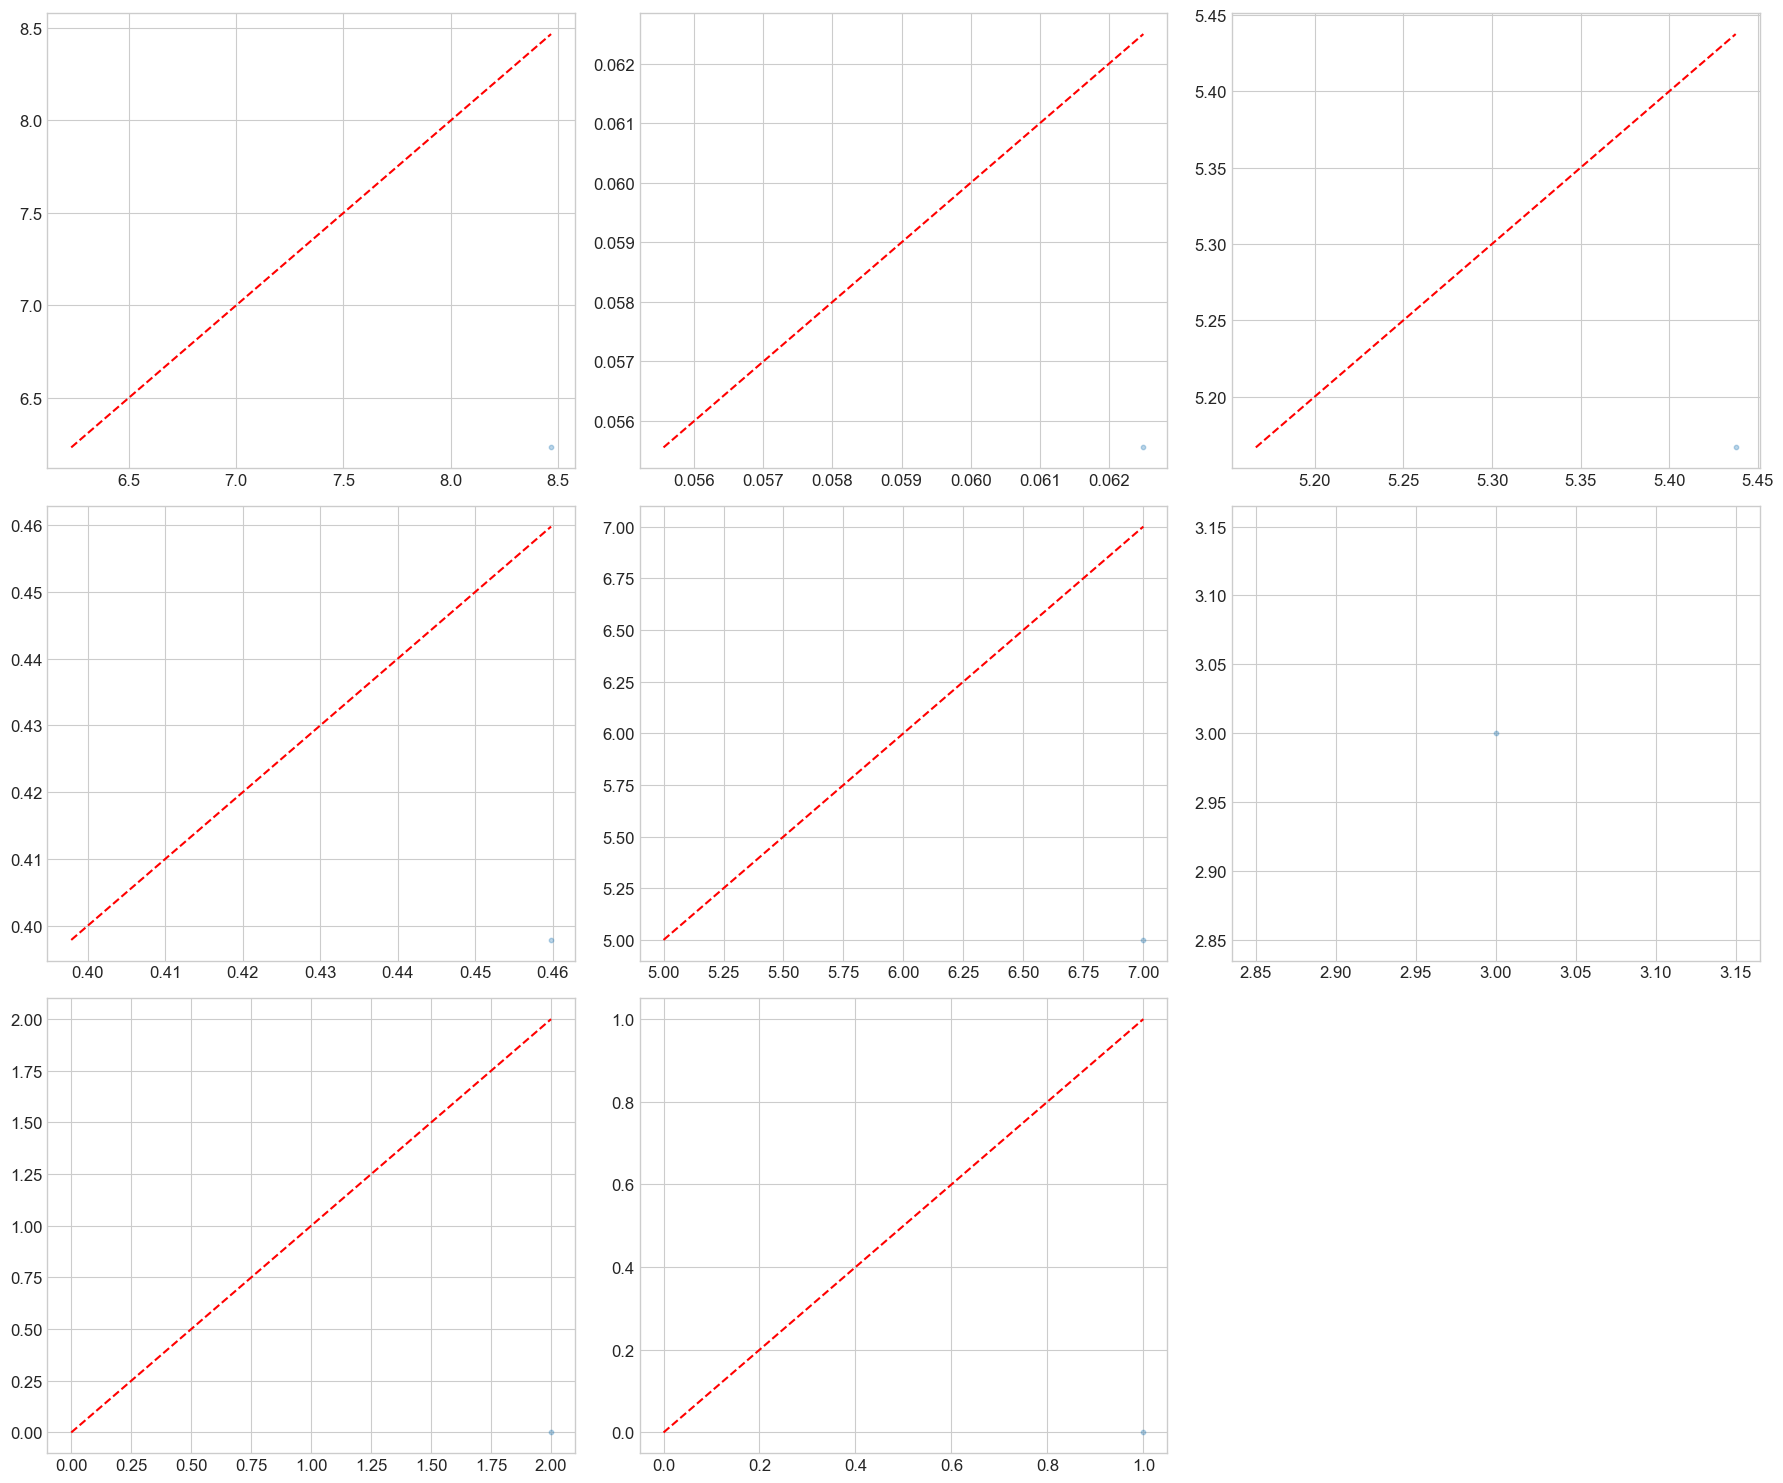

In [64]:
plt.figure(figsize=(18, 12))
for i, metric in enumerate(key_metrics, 1):
    plt.subplot(2, 3, i)
    
    # Определяем заголовок диаграммы
    metric_name = metric.replace('_change', '').replace('_', ' ').title()
    
    # Строим гистограмму
    sns.histplot(df_changes[metric], kde=True, bins=30)
    
    # Добавляем вертикальную линию на нуле
    plt.axvline(x=0, color='r', linestyle='--')
    
    # Вычисляем процент случаев с уменьшением и увеличением
    decreased = (df_changes[metric] < -5).sum() / len(df_changes) * 100
    increased = (df_changes[metric] > 5).sum() / len(df_changes) * 100
    same = 100 - decreased - increased
    
    # Добавляем аннотации
    plt.annotate(f'Уменьшение: {decreased:.1f}%', xy=(0.05, 0.95), xycoords='axes fraction', 
                 fontsize=10, ha='left', va='top', color='green')
    plt.annotate(f'Увеличение: {increased:.1f}%', xy=(0.95, 0.95), xycoords='axes fraction', 
                 fontsize=10, ha='right', va='top', color='red')
    plt.annotate(f'Без изменений: {same:.1f}%', xy=(0.5, 0.95), xycoords='axes fraction', 
                 fontsize=10, ha='center', va='top', color='blue')
    
    # Устанавливаем заголовок и метки
    plt.title(f'Изменение метрики "{metric_name}"')
    plt.xlabel('Процент изменения (%)')
    plt.ylabel('Количество текстов')
    
    # Ограничиваем размер осей для лучшей визуализации
    plt.xlim(-100, 100)
    
    plt.tight_layout()

plt.savefig('key_metrics_changes_distribution.png', dpi=300, bbox_inches='tight')
plt.close()

# 4. Модель "что было - что стало" для ключевых метрик
plt.figure(figsize=(18, 15))

# Выбираем наиболее интересные метрики для анализа
selected_metrics = [
    'flesch_kincaid_grade', 'complex_sentences_ratio', 
    'avg_sent_length', 'noun_ratio', 'max_syntactic_depth',
    'participles_count', 'passive_constructions', 'bureaucratic_phrases'
]

for i, metric in enumerate(selected_metrics, 1):
    plt.subplot(3, 3, i)
    
    # Получаем данные для каждой пары текстов
    orig_values = []
    para_values = []
    
    for text_id in df_metrics[df_metrics['text_type'] == 'original']['text_id'].unique():
        orig_value = df_metrics[(df_metrics['text_type'] == 'original') & 
                              (df_metrics['text_id'] == text_id)][metric].values
        
        para_value = df_metrics[(df_metrics['text_type'] == 'paraphrased') & 
                              (df_metrics['text_id'] == text_id)][metric].values
        
        if len(orig_value) > 0 and len(para_value) > 0:
            orig_values.append(orig_value[0])
            para_values.append(para_value[0])
    
    # Создаем точечную диаграмму "было-стало"
    plt.scatter(orig_values, para_values, alpha=0.3, s=10)
    
    # Добавляем диагональ (линию без изменений)
    max_val = max(max(orig_values), max(para_values))
    min_val = min(min(orig_values), min(para_values))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')

In [66]:

    # Добавляем регрессионную линию для отображения тренда
    z = np.polyfit(orig_values, para_values, 1)
    p = np.poly1d(z)
    plt.plot([min_val, max_val], [p(min_val), p(max_val)], 'g-')
    
    # Считаем интересную статистику
    below_diag = sum(p < o for p, o in zip(para_values, orig_values))
    above_diag = sum(p > o for p, o in zip(para_values, orig_values))
    on_diag = len(para_values) - below_diag - above_diag
    
    below_pct = below_diag / len(para_values) * 100
    above_pct = above_diag / len(para_values) * 100
    
    # Добавляем аннотации
    plt.annotate(f'Уменьшение: {below_pct:.1f}%', xy=(0.05, 0.95), xycoords='axes fraction', 
                fontsize=10, ha='left', va='top', color='green')
    plt.annotate(f'Увеличение: {above_pct:.1f}%', xy=(0.95, 0.95), xycoords='axes fraction', 
                fontsize=10, ha='right', va='top', color='red')
    
    # Добавляем заголовок и подписи
    metric_name = metric.replace('_', ' ').title()
    plt.title(f'{metric_name}: Оригинал vs Перефраз')
    plt.xlabel('Значение в оригинале')
    plt.ylabel('Значение в перефразе')
    
    plt.tight_layout()

plt.savefig('metrics_before_after.png', dpi=300, bbox_inches='tight')
plt.close()

# 5. Тепловая карта корреляций изменений метрик
change_columns = [col for col in df_changes.columns if col.endswith('_change')]
correlation_matrix = df_changes[change_columns].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', 
           linewidths=0.5, vmin=-1, vmax=1)
plt.title('Корреляция между изменениями различных метрик сложности')
plt.tight_layout()
plt.savefig('change_correlations.png', dpi=300, bbox_inches='tight')
plt.close()

# 6. Общая визуализация сложности: радарная диаграмма
# Выбираем ключевые метрики для радара
radar_metrics = [
    'flesch_kincaid_grade', 'complex_sentences_ratio',
    'participles_count', 'gerunds_count', 
    'max_syntactic_depth', 'noun_ratio',
    'passive_constructions', 'bureaucratic_phrases'
]

/var/folders/0v/tzcygl612vvdz00kp8wyv3th0000gn/T/ipykernel_55578/749124044.py:2: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(orig_values, para_values, 1)


In [68]:
# Нормализуем данные для отображения на одной шкале
def normalize_metrics(df, metrics):
    norm_df = df.copy()
    for metric in metrics:
        max_val = df[metric].max()
        min_val = df[metric].min()
        if max_val != min_val:
            norm_df[metric] = (df[metric] - min_val) / (max_val - min_val)
        else:
            norm_df[metric] = 0
    return norm_df

norm_metrics = normalize_metrics(df_metrics, radar_metrics)
orig_avg = norm_metrics[norm_metrics['text_type'] == 'original'][radar_metrics].mean()
para_avg = norm_metrics[norm_metrics['text_type'] == 'paraphrased'][radar_metrics].mean()

In [70]:
# Создаем радарную диаграмму
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, polar=True)

# Устанавливаем углы для каждой метрики
angles = np.linspace(0, 2*np.pi, len(radar_metrics), endpoint=False).tolist()
angles += angles[:1]  # Замыкаем диаграмму

# Преобразуем значения в список
orig_values = orig_avg.tolist()
para_values = para_avg.tolist()

# Замыкаем значения
orig_values += orig_values[:1]
para_values += para_values[:1]

# Рисуем оригинальные значения
ax.plot(angles, orig_values, 'o-', linewidth=2, label='Оригинал', color='#3498db')
ax.fill(angles, orig_values, alpha=0.25, color='#3498db')

# Рисуем значения для перефраза
ax.plot(angles, para_values, 'o-', linewidth=2, label='Перефраз', color='#2ecc71')
ax.fill(angles, para_values, alpha=0.25, color='#2ecc71')

# Устанавливаем метки и заголовок
ax.set_thetagrids(np.degrees(angles[:-1]), [m.replace('_', '\n') for m in radar_metrics])
ax.set_title('Сравнение сложности текста: Оригинал vs Перефраз', size=15)
ax.grid(True)

# Добавляем легенду
plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig('complexity_radar.png', dpi=300, bbox_inches='tight')
plt.close()

# Выводим сводную таблицу средних значений метрик
print(summary)

# Выводим примеры изменений в сложности текста
# Находим тексты с наибольшим упрощением и усложнением по индексу Флеша-Кинкейда
simplification_idx = df_changes['flesch_kincaid_grade_change'].idxmin()
complication_idx = df_changes['flesch_kincaid_grade_change'].idxmax()

simplification_text_id = df_changes.loc[simplification_idx, 'text_id']
complication_text_id = df_changes.loc[complication_idx, 'text_id']

print("\nПример наибольшего упрощения текста (по Flesch-Kincaid):")
print(f"ID текста: {simplification_text_id}")
print(f"Изменение индекса Флеша-Кинкейда: {df_changes.loc[simplification_idx, 'flesch_kincaid_grade_change']:.2f}%")

print("\nПример наибольшего усложнения текста (по Flesch-Kincaid):")
print(f"ID текста: {complication_text_id}")
print(f"Изменение индекса Флеша-Кинкейда: {df_changes.loc[complication_idx, 'flesch_kincaid_grade_change']:.2f}%")

# Выводим другие интересные статистические данные
print("\nПроцент текстов, упрощенных после перефразирования:")
print(f"По индексу Флеша-Кинкейда: {(df_changes['flesch_kincaid_grade_change'] < 0).mean()*100:.2f}%")
print(f"По синтаксической глубине: {(df_changes['max_syntactic_depth_change'] < 0).mean()*100:.2f}%")
print(f"По количеству причастий: {(df_changes['participles_count_change'] < 0).mean()*100:.2f}%")

print("\nПроцент текстов с существенным изменением сложности (более 20%):")
print(f"Упрощено: {(df_changes['flesch_kincaid_grade_change'] < -20).mean()*100:.2f}%")
print(f"Усложнено: {(df_changes['flesch_kincaid_grade_change'] > 20).mean()*100:.2f}%")


     text_type  avg_sent_length  max_syntactic_depth  flesch_kincaid_grade  \
0     original         5.437500                  7.0              8.466681   
1  paraphrased         5.166667                  5.0              6.232043   

   participles_count  gerunds_count  passive_constructions  \
0                3.0            0.0                    2.0   
1                3.0            0.0                    0.0   

   modal_constructions  pointer_words  bureaucratic_phrases  \
0                  1.0            6.0                   1.0   
1                  2.0            0.0                   0.0   

   complex_sentences_ratio  noun_ratio  verb_ratio  adj_ratio  \
0                 0.062500    0.459770    0.126437   0.091954   
1                 0.055556    0.397849    0.161290   0.043011   

   max_consecutive_nouns  consecutive_nouns_groups  \
0                    5.0                      26.0   
1                    3.0                      26.0   

   three_plus_consecutive_nou

In [ ]:
# Визуализация метрик сложности для оригинальных и перефразированных текстов

!Сравнение всех метрик

В этой визуализации для каждой метрики показаны значения в оригинальных и перефразированных текстах, а также процент изменения. Отрицательный процент (зеленый) означает упрощение, положительный (красный) - усложнение.

!Метрики по категориям

Здесь метрики сгруппированы по категориям: удобочитаемость, синтаксическая сложность, стиль и части речи. Это позволяет легче увидеть, какие аспекты текста меняются при перефразировании.

!Распределение изменений

Эти гистограммы показывают распределение процентных изменений для ключевых метрик сложности. Видно, какая доля текстов упрощается, усложняется или остается примерно на том же уровне сложности.

!До и после перефразирования

Диаграммы "до-после" наглядно демонстрируют, как меняются конкретные метрики для каждого текста. Точки ниже диагональной линии указывают на упрощение, выше - на усложнение.

!Радарная диаграмма сложности

Радарная диаграмма позволяет увидеть общую картину изменений сложности по всем ключевым метрикам одновременно.

_Место для примеров встречаемости различных видов слов и конструкций_

In [11]:
!pip install umap

In [13]:
# Измерение семантических особенностей перефразирования с помощью автоэнкодеров
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from tqdm.notebook import tqdm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModel
import umap

In [15]:
# Устанавливаем стиль для визуализации
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 10)

# Загружаем данные
with open('annotated_text_pairs.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Функция для получения эмбеддингов с помощью предобученной модели
def get_embeddings(texts, model_name="DeepPavlov/rubert-base-cased"):
    """Получение эмбеддингов для списка текстов с помощью предобученной модели."""
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    
    # Переносим модель на GPU, если доступно
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    
    embeddings = []
    
    # Обрабатываем тексты батчами для ускорения
    batch_size = 8
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Получение эмбеддингов"):
        batch_texts = texts[i:i+batch_size]
        
        # Токенизируем и подготавливаем входные данные
        encoded_input = tokenizer(batch_texts, padding=True, truncation=True, 
                                 return_tensors='pt', max_length=512)
        
        # Переносим данные на то же устройство, что и модель
        encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
        
        # Получаем эмбеддинги без вычисления градиентов
        with torch.no_grad():
            outputs = model(**encoded_input)
        
        # Берем [CLS] эмбеддинг для каждого текста (представление всего предложения)
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.extend(batch_embeddings)
    
    return np.array(embeddings)

In [17]:
# Подготовка данных
original_texts = []
paraphrased_texts = []
pair_ids = []

for i, pair in enumerate(data):
    if pair['original'] and pair['paraphrased']:
        original_texts.append(pair['original']['text'])
        paraphrased_texts.append(pair['paraphrased']['text'])
        pair_ids.append(i)

print(f"Загружено {len(original_texts)} пар текстов.")

# Получаем эмбеддинги для оригинальных и перефразированных текстов
print("Получение эмбеддингов оригинальных текстов...")
original_embeddings = get_embeddings(original_texts)
print("Получение эмбеддингов перефразированных текстов...")
paraphrased_embeddings = get_embeddings(paraphrased_texts)

Загружено 2867 пар текстов.
Получение эмбеддингов оригинальных текстов...


Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Получение эмбеддингов:   0%|          | 0/359 [00:00<?, ?it/s]

Получение эмбеддингов перефразированных текстов...


Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Получение эмбеддингов:   0%|          | 0/359 [00:00<?, ?it/s]

In [19]:
# Создаем простой автоэнкодер для изучения семантического пространства
class SimpleAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(SimpleAutoencoder, self).__init__()
        
        # Энкодер
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, encoding_dim)
        )
        
        # Декодер
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [21]:
# Объединяем эмбеддинги для обучения автоэнкодера
all_embeddings = np.vstack([original_embeddings, paraphrased_embeddings])
input_dim = all_embeddings.shape[1]
encoding_dim = 32  # Размерность скрытого представления

# Создаем и обучаем автоэнкодер
autoencoder = SimpleAutoencoder(input_dim, encoding_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder = autoencoder.to(device)

# Преобразуем данные в тензоры
all_embeddings_tensor = torch.FloatTensor(all_embeddings).to(device)
dataset = TensorDataset(all_embeddings_tensor, all_embeddings_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Оптимизатор и функция потерь
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Обучение автоэнкодера
epochs = 50
losses = []

In [23]:
print("Обучение автоэнкодера...")
for epoch in tqdm(range(epochs), desc="Эпохи"):
    epoch_loss = 0
    for batch_x, _ in dataloader:
        # Очистка градиентов
        optimizer.zero_grad()
        
        # Прямой проход
        _, reconstructed = autoencoder(batch_x)
        
        # Расчет потерь
        loss = criterion(reconstructed, batch_x)
        
        # Обратное распространение
        loss.backward()
        
        # Обновление весов
        optimizer.step()
        
        epoch_loss += loss.item()
    
    # Среднее значение потерь по эпохе
    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Эпоха {epoch+1}/{epochs}, Потери: {avg_loss:.6f}")

# Получаем скрытые представления для оригинальных и перефразированных текстов
autoencoder.eval()
with torch.no_grad():
    original_encoded, _ = autoencoder(torch.FloatTensor(original_embeddings).to(device))
    paraphrased_encoded, _ = autoencoder(torch.FloatTensor(paraphrased_embeddings).to(device))

# Переносим данные обратно на CPU
original_encoded = original_encoded.cpu().numpy()
paraphrased_encoded = paraphrased_encoded.cpu().numpy()

Обучение автоэнкодера...


Эпохи:   0%|          | 0/50 [00:00<?, ?it/s]

Эпоха 10/50, Потери: 0.007900
Эпоха 20/50, Потери: 0.006195
Эпоха 30/50, Потери: 0.005449
Эпоха 40/50, Потери: 0.004942
Эпоха 50/50, Потери: 0.004780


In [25]:
# 1. Визуализация потерь при обучении автоэнкодера
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Loss Dynamics During Autoencoder Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.grid(True)
plt.savefig('autoencoder_loss.png', dpi=300, bbox_inches='tight')
plt.close()

In [27]:
# 2. Визуализация векторов с помощью t-SNE
print("Визуализация данных с помощью t-SNE...")
# Объединяем скрытые представления для t-SNE
combined_encoded = np.vstack([original_encoded, paraphrased_encoded])

Визуализация данных с помощью t-SNE...


In [29]:
# Применяем t-SNE для визуализации
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(combined_encoded)

# Разделяем результаты обратно
tsne_original = tsne_results[:len(original_encoded)]
tsne_paraphrased = tsne_results[len(original_encoded):]

# Строим график
plt.figure(figsize=(12, 10))
plt.scatter(tsne_original[:, 0], tsne_original[:, 1], c='blue', label='Original texts', alpha=0.7)
plt.scatter(tsne_paraphrased[:, 0], tsne_paraphrased[:, 1], c='green', label='Paraphrased texts', alpha=0.7)

# Соединяем соответствующие пары линиями
for i in range(len(tsne_original)):
    plt.plot([tsne_original[i, 0], tsne_paraphrased[i, 0]], 
             [tsne_original[i, 1], tsne_paraphrased[i, 1]], 'gray', alpha=0.3)

plt.title('t-SNE Visualization of Text Hidden Representations')
plt.legend()
plt.grid(True)
plt.savefig('tsne_visualization.png', dpi=300, bbox_inches='tight')
plt.close()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [31]:
pip install umap-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [33]:
# 3. Визуализация с помощью UMAP
# После установки импортируем правильно
import umap.umap_ as umap

print("Визуализация данных с помощью UMAP...")
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
umap_results = umap_reducer.fit_transform(combined_encoded)

# Разделяем результаты 
umap_original = umap_results[:len(original_encoded)]
umap_paraphrased = umap_results[len(original_encoded):]

# Строим график
plt.figure(figsize=(12, 10))
plt.scatter(umap_original[:, 0], umap_original[:, 1], c='blue', label='Original texts', alpha=0.7)
plt.scatter(umap_paraphrased[:, 0], umap_paraphrased[:, 1], c='green', label='Paraphrased texts', alpha=0.7)

# Соединяем соответствующие пары линиями
for i in range(len(umap_original)):
    plt.plot([umap_original[i, 0], umap_paraphrased[i, 0]], [umap_original[i, 1], umap_paraphrased[i, 1]], 'gray', alpha=0.3)

plt.title('UMAP Visualization of Text Hidden Representations')
plt.legend()
plt.grid(True)
plt.savefig('umap_visualization.png', dpi=300, bbox_inches='tight')
plt.close()

Визуализация данных с помощью UMAP...


In [35]:
# 4. Расчет семантического расстояния между оригинальными и перефразированными текстами
distances = np.sqrt(np.sum((original_encoded - paraphrased_encoded)**2, axis=1))

plt.figure(figsize=(12, 6))
plt.hist(distances, bins=30, alpha=0.7, color='purple')
plt.axvline(x=distances.mean(), color='red', linestyle='--', label=f'Среднее: {distances.mean():.2f}')
plt.title('Distribution of Semantic Distances Between Originals and Paraphrases')
plt.xlabel('Euclidean Distance in Latent Space')
plt.ylabel('Number of Text Pairs')
plt.legend()
plt.grid(True)
plt.savefig('semantic_distances.png', dpi=300, bbox_inches='tight')
plt.close()

In [37]:
# 5. Визуализация наиболее и наименее измененных текстов
# Находим индексы текстов с наибольшим и наименьшим изменением
most_changed_idx = np.argsort(distances)[-5:][::-1]
least_changed_idx = np.argsort(distances)[:5]

print("\nПары с наибольшим семантическим изменением:")
for idx in most_changed_idx:
    print(f"Пара #{pair_ids[idx]}, Расстояние: {distances[idx]:.4f}")
    print(f"Оригинал: {original_texts[idx][:100]}...")
    print(f"Перефраз: {paraphrased_texts[idx][:100]}...")
    print("-" * 80)

print("\nПары с наименьшим семантическим изменением:")
for idx in least_changed_idx:
    print(f"Пара #{pair_ids[idx]}, Расстояние: {distances[idx]:.4f}")
    print(f"Оригинал: {original_texts[idx][:100]}...")
    print(f"Перефраз: {paraphrased_texts[idx][:100]}...")
    print("-" * 80)


Пары с наибольшим семантическим изменением:
Пара #2100, Расстояние: 6.9745
Оригинал: Замечания относительно удаления данных с твердотельного диска mSATA Поскольку компьютеры задействова...
Перефраз: , if the thing is a thing, the thing is a thing, if the thing is a thing, if the thing is a thing, i...
--------------------------------------------------------------------------------
Пара #1634, Расстояние: 5.6688
Оригинал: Использование функции Battery Check (Проверка батареи) Battery Check (Проверка батареи)является част...
Перефраз: Функция Battery Check (Проверка батареи) входит в пакет Total Care Advisor. Она показывает состояние...
--------------------------------------------------------------------------------
Пара #632, Расстояние: 5.5334
Оригинал: 3 Настройка экрана Настройка параметров экрана, например, яркости. Приведено подробное описание кажд...
Перефраз: ## 3. Настройка экрана

В этом разделе описаны параметры настройки экрана, включая яркость. Подробны...
-----------------

In [39]:
# 6. Анализ главных компонент скрытого представления
pca = PCA(n_components=2)
pca_results = pca.fit_transform(combined_encoded)

# Разделяем результаты
pca_original = pca_results[:len(original_encoded)]
pca_paraphrased = pca_results[len(original_encoded):]

# Строим график
plt.figure(figsize=(12, 10))
plt.scatter(pca_original[:, 0], pca_original[:, 1], c='blue', label='Original texts', alpha=0.7)
plt.scatter(pca_paraphrased[:, 0], pca_paraphrased[:, 1], c='green', label='Paraphrased texts', alpha=0.7)

# Соединяем соответствующие пары линиями
for i in range(len(pca_original)):
    plt.plot([pca_original[i, 0], pca_paraphrased[i, 0]], 
             [pca_original[i, 1], pca_paraphrased[i, 1]], 'gray', alpha=0.3)

plt.title('PCA Visualization of Text Hidden Representations')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} дисперсии)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} дисперсии)')
plt.legend()
plt.grid(True)
plt.savefig('pca_visualization.png', dpi=300, bbox_inches='tight')
plt.close()

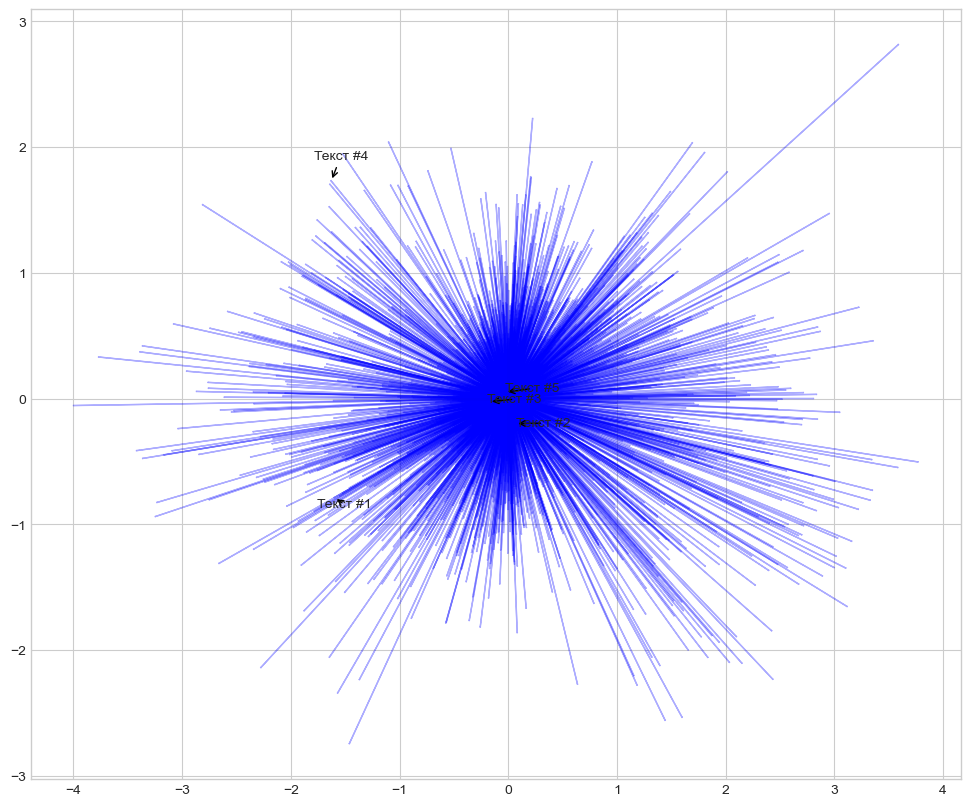

In [41]:
# 7. Визуализация направлений перефразирования
# Вычисляем вектора перефразирования (различия между оригиналом и перефразом)
paraphrase_vectors = paraphrased_encoded - original_encoded

# Применяем PCA к векторам перефразирования
pca_vectors = PCA(n_components=2)
pca_vector_results = pca_vectors.fit_transform(paraphrase_vectors)

# Строим график векторов перефразирования
plt.figure(figsize=(12, 10))

# Создаем scatter plot с началом в точке (0,0) для всех векторов
plt.scatter([0] * len(pca_vector_results), [0] * len(pca_vector_results), 
           c='red', alpha=0.1, s=10, label='Начало вектора')

# Рисуем стрелки направлений перефразирования
for i in range(len(pca_vector_results)):
    plt.arrow(0, 0, pca_vector_results[i, 0], pca_vector_results[i, 1], 
             alpha=0.3, width=0.001, head_width=0.005, color='blue')

# Добавляем несколько примеров с аннотациями
for i in range(min(5, len(pca_vector_results))):
    plt.annotate(f"Текст #{i+1}", 
                xy=(pca_vector_results[i, 0], pca_vector_results[i, 1]),
                xytext=(pca_vector_results[i, 0]*1.1, pca_vector_results[i, 1]*1.1),
                arrowprops=dict(arrowstyle='->'))

plt.title('Направления перефразирования в пространстве главных компонент')
plt.xlabel(f'PC1 ({pca_vectors.explained_variance_ratio_[0]:.2%} дисперсии)')
plt.ylabel(f'PC2 ({pca_vectors.explained_variance_ratio_[1]:.2%} дисперсии)')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
plt.grid(True)
plt.savefig('paraphrase_directions.png', dpi=300, bbox_inches='tight')
plt.close()

# 8. Кластеризация векторов перефразирования
from sklearn.cluster import KMeans

# Количество кластеров
n_clusters = 7

# Применяем KMeans к векторам перефразирования
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(paraphrase_vectors)

# Визуализируем кластеры в скрытом пространстве (используем UMAP)
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
paraphrase_umap = umap_reducer.fit_transform(paraphrase_vectors)

In [45]:
plt.title('Directions of Paraphrasing in Principal Component Space')
plt.xlabel(f'PC1 ({pca_vectors.explained_variance_ratio_[0]:.2%} дисперсии)')
plt.ylabel(f'PC2 ({pca_vectors.explained_variance_ratio_[1]:.2%} дисперсии)')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
plt.grid(True)
plt.savefig('paraphrase_directions.png', dpi=300, bbox_inches='tight')
plt.close()

# 8. Кластеризация векторов перефразирования
from sklearn.cluster import KMeans

# Количество кластеров
n_clusters = 4

# Применяем KMeans к векторам перефразирования
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(paraphrase_vectors)

# Визуализируем кластеры в скрытом пространстве (используем UMAP)
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
paraphrase_umap = umap_reducer.fit_transform(paraphrase_vectors)

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [47]:
plt.figure(figsize=(12, 10))
for i in range(n_clusters):
    # Выбираем точки текущего кластера
    cluster_points = paraphrase_umap[cluster_labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Кластер {i+1}', alpha=0.7)

plt.title('Paraphrasing Vectors Clustering')
plt.legend()
plt.grid(True)
plt.savefig('paraphrase_clusters.png', dpi=300, bbox_inches='tight')
plt.close()

In [55]:
# 9. Анализ кластеров: примеры текстов из каждого кластера
print("\nПримеры пар текстов из каждого кластера:")

# Open a file to save the examples
with open('cluster_examples.txt', 'w', encoding='utf-8') as f:
    f.write("ПРИМЕРЫ ПАР ТЕКСТОВ ИЗ КАЖДОГО КЛАСТЕРА\n\n")
    
    for cluster_id in range(n_clusters):
        print(f"\nКластер {cluster_id+1}:")
        f.write(f"\nКЛАСТЕР {cluster_id+1}:\n")
        
        # Получаем индексы текстов в кластере
        cluster_indices = np.where(cluster_labels == cluster_id)[0]
        
        # Берем до 3 примеров из кластера
        examples = cluster_indices[:3]
        
        for idx in examples:
            print(f"Пара #{pair_ids[idx]}")
            print(f"Оригинал: {original_texts[idx][:100]}...")
            print(f"Перефраз: {paraphrased_texts[idx][:100]}...")
            print("-" * 60)
            
            # Write to file with full text
            f.write(f"Пара #{pair_ids[idx]}\n")
            f.write(f"Оригинал: {original_texts[idx]}\n")
            f.write(f"Перефраз: {paraphrased_texts[idx]}\n")
            f.write("-" * 60 + "\n")

print(f"Examples saved to 'cluster_examples.txt'")


Примеры пар текстов из каждого кластера:

Кластер 1:
Пара #0
Оригинал: Перед первым использованием необходимо электрошкаф и весь комплект (противень, поддон и решётку) вым...
Перефраз: Перед первым использованием вымойте электрошкаф и весь комплект (противень, поддон и решётку) теплым...
------------------------------------------------------------
Пара #3
Оригинал: 3. Не замыкайте аккумуляторную батарею, одновременно прикасаясь к ее контактам одним металлическим п...
Перефраз: 3. Не касайтесь контактов аккумулятора одним металлическим предметом — это вызовет короткое замыкани...
------------------------------------------------------------
Пара #5
Оригинал: Полная зарядка батареи Батарея разряжена, требуется подзарядка 20 21 ВАЖНО: Дата изготовления указан...
Перефраз: Руководство по эксплуатации аккумулятора

Зарядка и использование:
- Заряжать при температуре 0-35°C...
------------------------------------------------------------

Кластер 2:
Пара #7
Оригинал: Lenovo OneKey Recovery Sy

In [57]:
# 10. Расчет семантического сходства с помощью косинусного расстояния
from sklearn.metrics.pairwise import cosine_similarity

# Вычисляем косинусное сходство между оригиналами и перефразами
cosine_similarities = []
for i in range(len(original_encoded)):
    similarity = cosine_similarity(
        original_encoded[i].reshape(1, -1),
        paraphrased_encoded[i].reshape(1, -1)
    )[0][0]
    cosine_similarities.append(similarity)

plt.figure(figsize=(12, 6))
plt.hist(cosine_similarities, bins=30, alpha=0.7, color='teal')
plt.axvline(x=np.mean(cosine_similarities), color='red', linestyle='--', 
           label=f'Среднее: {np.mean(cosine_similarities):.4f}')
plt.title('Distribution of Cosine Similarity Between Originals and Paraphrases')
plt.xlabel('Cosine Similarity')
plt.ylabel('Number of Text Pairs')
plt.legend()
plt.grid(True)
plt.savefig('cosine_similarity.png', dpi=300, bbox_inches='tight')
plt.close()

In [59]:
# 11. Визуализация зависимости семантического сходства от длины текста
original_lengths = [len(text.split()) for text in original_texts]
average_lengths = [(len(original_texts[i].split()) + len(paraphrased_texts[i].split())) / 2 
                  for i in range(len(original_texts))]

plt.figure(figsize=(12, 6))
plt.scatter(average_lengths, cosine_similarities, alpha=0.6, c='purple')
plt.xlabel('Average Text Length (words)')
plt.ylabel('Cosine Similarity')
plt.title('Relationship Between Semantic Similarity and Text Length')
plt.grid(True)

# Добавляем линию тренда
z = np.polyfit(average_lengths, cosine_similarities, 1)
p = np.poly1d(z)
plt.plot(np.unique(average_lengths), p(np.unique(average_lengths)), 'r--', 
         label=f'Тренд: y = {z[0]:.6f}x + {z[1]:.4f}')
plt.legend()
plt.savefig('similarity_vs_length.png', dpi=300, bbox_inches='tight')
plt.close()

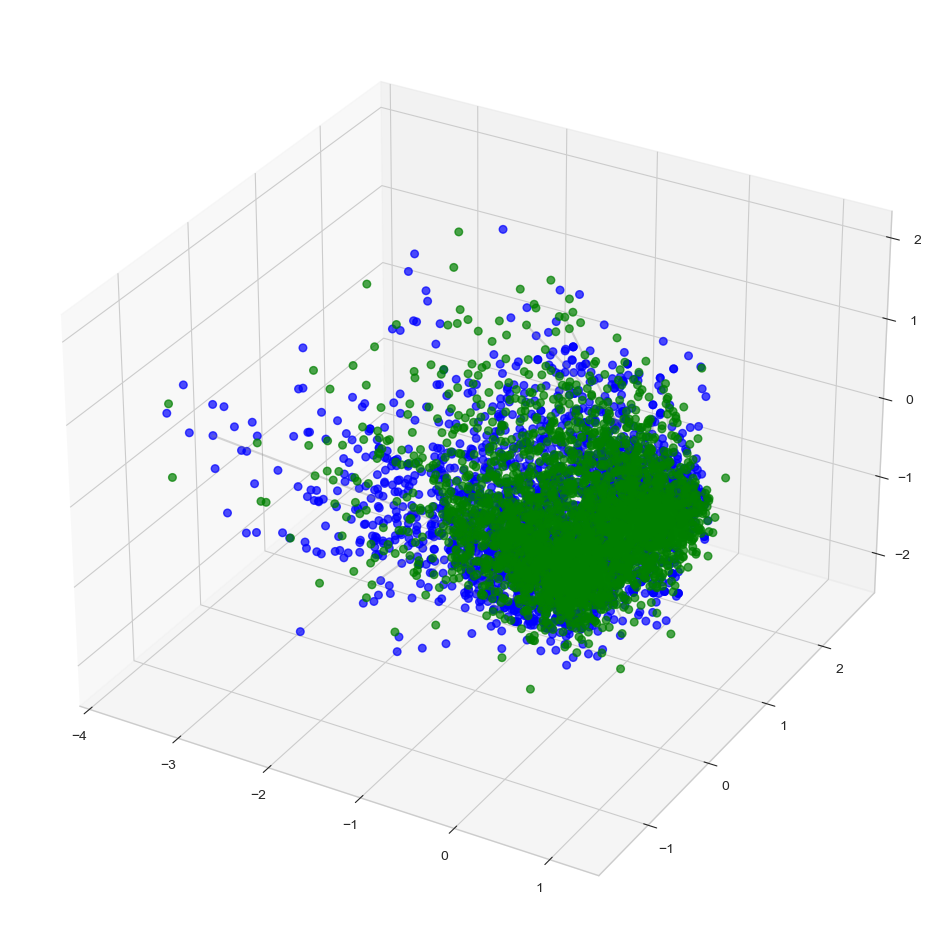

In [69]:
# 12. Создаем интерактивную 3D визуализацию с помощью PCA
from mpl_toolkits.mplot3d import Axes3D

# Применяем PCA с 3 компонентами
pca_3d = PCA(n_components=3)
pca_3d_results = pca_3d.fit_transform(combined_encoded)

# Разделяем результаты
pca_3d_original = pca_3d_results[:len(original_encoded)]
pca_3d_paraphrased = pca_3d_results[len(original_encoded):]

# Создаем 3D визуализацию
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

# Строим точки
ax.scatter(pca_3d_original[:, 0], pca_3d_original[:, 1], pca_3d_original[:, 2], 
          c='blue', label='Original texts', alpha=0.7, s=30)
ax.scatter(pca_3d_paraphrased[:, 0], pca_3d_paraphrased[:, 1], pca_3d_paraphrased[:, 2], 
          c='green', label='Paraphrased texts', alpha=0.7, s=30)

# Соединяем соответствующие пары линиями (ограничимся 50 парами для наглядности)
max_pairs = min(50, len(pca_3d_original))
for i in range(max_pairs):
    ax.plot([pca_3d_original[i, 0], pca_3d_paraphrased[i, 0]],
            [pca_3d_original[i, 1], pca_3d_paraphrased[i, 1]],
            [pca_3d_original[i, 2], pca_3d_paraphrased[i, 2]], 'gray', alpha=0.3)

In [71]:

    ax.set_title('3D PCA Visualization of Text Hidden Representations')
    ax.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.2%})')
    ax.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.2%})')
    ax.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.2%})')
    ax.legend()
    plt.savefig('pca_3d_visualization.png', dpi=300, bbox_inches='tight')
    plt.close()

In [73]:
# 13. Создание тепловой карты корреляций между различными метриками
# Создаем DataFrame с метриками
df_metrics = pd.DataFrame({
    'semantic_distance': distances,
    'cosine_similarity': cosine_similarities,
    'original_length': original_lengths,
    'cluster': cluster_labels
})

# Если есть данные о сложности текста из предыдущего анализа, добавляем их
try:
    complexity_df = pd.read_csv('complexity_metrics.csv')
    
    # Добавляем только метрики для перефразированных текстов
    paraphrased_complexity = complexity_df[complexity_df['text_type'] == 'paraphrased']
    
    # Проверяем, что количество строк совпадает
    if len(paraphrased_complexity) == len(df_metrics):
        for col in ['flesch_kincaid_grade', 'complex_sentences_ratio', 'max_syntactic_depth']:
            if col in paraphrased_complexity.columns:
                df_metrics[col] = paraphrased_complexity[col].values
except:
    print("Файл с метриками сложности не найден, продолжаем без этих данных.")

# Рассчитываем корреляции
corr_matrix = df_metrics.corr()

In [228]:
# Визуализируем тепловую карту корреляций
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Корреляции между метриками перефразирования')
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.close()

In [229]:
# 14. Сохраняем результаты анализа в файл
results = {
    'average_semantic_distance': float(np.mean(distances)),
    'average_cosine_similarity': float(np.mean(cosine_similarities)),
    'cluster_sizes': [int((cluster_labels == i).sum()) for i in range(n_clusters)],
    'cluster_examples': {}
}

# Добавляем примеры текстов из каждого кластера
for cluster_id in range(n_clusters):
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    examples = cluster_indices[:3]  # берем до 3 примеров
    
    cluster_examples = []
    for idx in examples:
        cluster_examples.append({
            'pair_id': int(pair_ids[idx]),
            'original': original_texts[idx],
            'paraphrased': paraphrased_texts[idx],
            'semantic_distance': float(distances[idx]),
            'cosine_similarity': float(cosine_similarities[idx])
        })
    
    results['cluster_examples'][f'cluster_{cluster_id+1}'] = cluster_examples

# Сохраняем результаты в JSON файл
with open('semantic_analysis_results.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=4)

print("\nАнализ завершен! Результаты сохранены в файлы:")
print("- semantic_analysis_results.json")
print("- tsne_visualization.png")
print("- umap_visualization.png")
print("- semantic_distances.png")
print("- paraphrase_directions.png")
print("- paraphrase_clusters.png")
print("- cosine_similarity.png")
print("- similarity_vs_length.png")
print("- pca_3d_visualization.png")
print("- correlation_heatmap.png")


Анализ завершен! Результаты сохранены в файлы:
- semantic_analysis_results.json
- tsne_visualization.png
- umap_visualization.png
- semantic_distances.png
- paraphrase_directions.png
- paraphrase_clusters.png
- cosine_similarity.png
- similarity_vs_length.png
- pca_3d_visualization.png
- correlation_heatmap.png


In [235]:
"""
Этот код выполняет следующие задачи:
1. Извлекает эмбеддинги из текстов с помощью модели RuBERT
2. Создает и обучает автоэнкодер для получения скрытого представления текстов
3. Визуализирует семантическое пространство с помощью t-SNE, UMAP и PCA
4. Анализирует направления перефразирования и кластеризует векторы изменений
5. Вычисляет семантические расстояния и сходства между оригиналами и перефразами
6. Создает различные визуализации для анализа семантических особенностей
7. Сохраняет результаты анализа в JSON файл

Для работы кода потребуются библиотеки: pandas, numpy, matplotlib, seaborn, torch, transformers, scikit-learn, umap-learn.
"""

'\nЭтот код выполняет следующие задачи:\n1. Извлекает эмбеддинги из текстов с помощью модели RuBERT\n2. Создает и обучает автоэнкодер для получения скрытого представления текстов\n3. Визуализирует семантическое пространство с помощью t-SNE, UMAP и PCA\n4. Анализирует направления перефразирования и кластеризует векторы изменений\n5. Вычисляет семантические расстояния и сходства между оригиналами и перефразами\n6. Создает различные визуализации для анализа семантических особенностей\n7. Сохраняет результаты анализа в JSON файл\n\nДля работы кода потребуются библиотеки: pandas, numpy, matplotlib, seaborn, torch, transformers, scikit-learn, umap-learn.\n'